In [7]:
import pandas as pd
import numpy
import re
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='basic_analysis')


In [2]:
header_df = pd.read_json('~/WWData/money_diaries/data/raw_basic_info.json')
diary_df = pd.read_json('~/WWData/money_diaries/data/raw_diaries.json')

In [3]:
header_df = header_df.T

In [4]:
header_df['Salary'] = header_df['Salary'].combine_first(header_df['My Income'])
header_df['Occupation'] = header_df['Occupation'].combine_first(header_df['Industry'])
basic_df = header_df[['Occupation','Age','Location','Salary']]

In [13]:
def normalize_income(x):
    match = re.findall(r'\d+,\d+', str(x))
    y = 0
    if match :
        y = int(match[0].replace(',',''))
    return y

def normalize_age(x):
    match = re.findall(r'\d+', str(x))
    y = 0
    if match :
        y = int(match[0])
    return y
    
def get_coordinates(x):
    location = geolocator.geocode(x)
    lat=long=None
    if location is not None :
        lat = location.latitude
        long = location.longitude
        
    return (lat,long)
        
basic_df['Income'] = basic_df['Salary'].apply(lambda x: normalize_income(x))
basic_df['Age'] = basic_df['Age'].apply(lambda x: normalize_age(x))
basic_df[['lat','long']] = basic_df['Location'].apply(lambda x: pd.Series(get_coordinates(x)))

In [64]:
# TODO : Losing about 400 diaries
basic_df=basic_df.dropna()
basic_df[['Occupation','Age','Location','Income','lat','long']]
basic_df.describe()

,Age,Income,lat,long
count,858.000000,858.000000,858.000000,858.000000
mean,27.486014,67789.625874,36.826523,-77.013104
std,4.405673,51665.268941,13.402703,52.032597
min,19.000000,0.000000,-37.814218,-159.558768
25%,24.000000,41000.000000,34.053691,-105.047097
50%,27.000000,57500.000000,40.650104,-82.359193
75%,30.000000,80000.000000,41.875562,-74.006015
max,57.000000,511000.000000,64.445961,153.023499


In [61]:
## Plot -> Place,Occupation,Income Bubbles

import plotly.graph_objects as go

df = basic_df
df['text'] = df['Location'] + '<br>Income:' + (df['Income']).astype(str) + '<br>Occupation:' + df['Occupation']
limits = [(10000,50000),(50001,70000),(70001 ,100000),(100001,300000),(300001,600000)]
colors = ["royalblue","crimson","lightseagreen","orange","lightblue"]
cities = []
scale = 500

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    cond = (
                (df['Income'] >= lim[0]) & 
                (df['Income'] <= lim[1])
            )
    df_sub = df[cond]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['long'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Income']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = 'US City,Occupation,Income<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

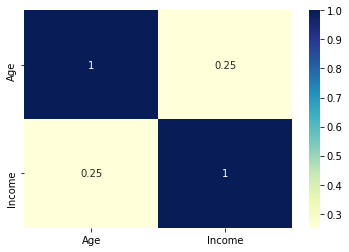

In [71]:
import seaborn as sn
import matplotlib.pyplot as plt

df = basic_df[['Age','Income']]
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

In [72]:
## Age and Income Scatter Plot

import plotly.express as px

df = basic_df
fig = px.scatter(x=df['Age'], y=df['Income'])
fig.show()